In [1]:
import sympy as sp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
x, y, m, n, a, b, ν, G, J = sp.symbols('x y m n a b nu G J')
Φmn = sp.symbols('Phimn', cls=sp.Function)

In [3]:
Φmn = - ν/(1 + ν)/J*8*b**3 / sp.pi**4*(-1)**(m+n-1)*sp.cos((2*m+1)/(2*a)*sp.pi*x)*sp.sin(n*sp.pi*y/b)/((2*m+1)*n*((2*m+1)**2*b**2/(4*a**2)+n**2))

In [4]:
Φmn

-8*(-1)**(m + n - 1)*b**3*nu*sin(pi*n*y/b)*cos(pi*x*(2*m + 1)/(2*a))/(pi**4*J*n*(2*m + 1)*(n**2 + b**2*(2*m + 1)**2/(4*a**2))*(nu + 1))

In [5]:
τxz = sp.diff(Φmn,y)
τyz = -sp.diff(Φmn,x)

In [6]:
τxz

-8*(-1)**(m + n - 1)*b**2*nu*cos(pi*x*(2*m + 1)/(2*a))*cos(pi*n*y/b)/(pi**3*J*(2*m + 1)*(n**2 + b**2*(2*m + 1)**2/(4*a**2))*(nu + 1))

In [7]:
τyz

-4*(-1)**(m + n - 1)*b**3*nu*sin(pi*x*(2*m + 1)/(2*a))*sin(pi*n*y/b)/(pi**3*J*a*n*(n**2 + b**2*(2*m + 1)**2/(4*a**2))*(nu + 1))

In [8]:
τxz_val = sp.lambdify((x,y,m,n,a,b,J,ν),τxz, 'numpy')

In [9]:
τyz_val = sp.lambdify((x,y,m,n,a,b,J,ν),τyz, 'numpy')

In [10]:
def ShearStresses(x_curr,y_curr, a_h, b_h, J, G1, ν1, num=101):
    
    τxz_acc = 0.5/J*(a_h**2 - x_curr**2)
    τyz_acc = 0.0
    
    # print("curr. x {0:.5f} - curr. y {1:.5f}".format(x_curr, y_curr))
    
    for m in range(num):
        for n in range(1,num):
            τxz_acc += τxz_val(x_curr, y_curr, m, n, a_h, b_h, J, ν1)
            τyz_acc += τyz_val(x_curr, y_curr, m, n, a_h, b_h, J, ν1)
    
    return τxz_acc, τyz_acc

In [11]:
a1 = 0.32
b1 = 0.16
J1 = 1/12.*(b1)*(a1)**3

E = 1
nu = 0.3
G = E/(2*(1+nu))

Torig = 1e-4
T = 1

x = np.linspace(-a1/2, a1/2,25)

τ_xz_mid = np.zeros_like(x)
τ_xz_edge = np.zeros_like(x)
τ_yz_mid = np.zeros_like(x)
τ_yz_edge = np.zeros_like(x)

p1, p2 = ShearStresses(0, 0, a1/2, b1/2, J1, G, nu)
q1, q2 = ShearStresses(a1/2, 0, a1/2, b1/2, J1, G, nu)


for i, x_act in enumerate(x):
    # print("i: {0} y: {1}".format(i, y_act))
    p1, q1 = ShearStresses(x_act, 0, a1/2, b1/2, J1, G, nu)
    τ_xz_mid[i] = p1
    τ_yz_mid[i] = q1
    p1, q1 = ShearStresses(x_act, b1/2, a1/2, b1/2, J1, G, nu)
    τ_xz_edge[i] = p1
    τ_yz_edge[i] = q1



In [12]:
tau_mid = np.genfromtxt('./Box3_Tz_face1_vert_mid.csv', skip_header=1, delimiter=',')
tau_edge = np.genfromtxt('./Box3_Tz_face1_vert_right.csv', skip_header=1, delimiter=',')

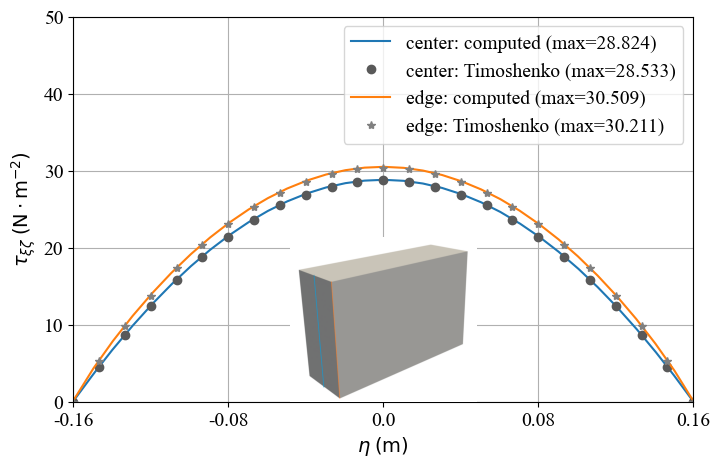

In [13]:
brick = plt.imread('./line_crop.png')

img = OffsetImage(brick, zoom=0.08, resample=True)
image_position = (-0.01, 2)  # Replace with the desired (x, y) coordinates

ab = AnnotationBbox(img, (0.5, 0), xycoords='axes fraction', box_alignment=(0.5,0.0), frameon=False, zorder=3)

fs = 18

plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']

# fs = 22

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(tau_mid[:,-1], tau_mid[:,7]/Torig, label='center: computed (max={0:.3f})'.format(np.max(tau_mid[:,7])/Torig))
plt.plot(x, T*τ_xz_mid, 'o', color=[0.35, 0.35, 0.35], label='center: Timoshenko (max={0:.3f})'.format(T*τ_xz_mid[13]))
plt.plot(tau_edge[:,-1], tau_edge[:,7]/Torig, label='edge: computed (max={0:.3f})'.format(np.max(tau_edge[:,7]/Torig)))
plt.plot(x, T*τ_xz_edge, '*', color=[0.5, 0.5, 0.5], label='edge: Timoshenko (max={0:.3f})'.format(T*τ_xz_edge[13]))
ax.set_xlim(-a1/2,a1/2)
ax.set_ylim(0,50)
ax.set_xlabel(r'$\eta$ $(\mathrm{m})$', fontsize=fs-4)
ax.set_ylabel(r'$\tau_{\xi \zeta}$ $\left( \mathrm{N} \cdot \mathrm{m}^{-2} \right)$', fontsize=fs-4)
#ax.set_xticks(ticks=np.linspace(-a1/2, a1/2, num=9))

act_ticks = [-0.16, -0.08, 0.0, 0.08, 0.16] #np.linspace(-b, b, num=5)
ax.set_xticks(ticks=act_ticks)
ax.set_xticklabels(act_ticks, fontsize=fs-4)
ax.tick_params(axis='y', labelsize=fs-4)


#ax.set_xticklabels(np.linspace(-b, b, num=9), fontsize=fs-4)
#ax.tick_params(axis='y', labelsize=fs-4)
#ax.ticklabel_format(axis='y', style='scientific', useOffset=False, useMathText=True, scilimits=(-1,1))
#ax.yaxis.offsetText.set_fontsize(fs-6)
ax.grid()
ax.legend(fontsize=fs-4, loc=1);
#ax.legend();


ax.add_artist(ab)

plt.savefig('tau_Tz_upd.png', dpi=300, bbox_inches='tight')


In [14]:
print('MID: computed max: {0} - Timoshenko {1}'.format(np.max(tau_mid[:,7])/Torig, T*τ_xz_mid[13]))
print('EDGE: computed max: {0} - Timoshenko {1}'.format(np.max(tau_edge[:,7])/Torig, T*τ_xz_edge[13]))

MID: computed max: 28.824271999999997 - Timoshenko 28.532972179926634
EDGE: computed max: 30.509344 - Timoshenko 30.210504366882144


In [15]:
q2

0.0